# NBS Titanic Challenge

## Purpose
This notebooks has the purpose to work with [Titanic Challenge](https://www.kaggle.com/competitions/titanic/overview) using machine learning algorithms.

## Methodology

The goal of this experiment is to predict if a passenger surviver or not with base in some features (e.g. age, sex, passenger class).

First of all, I have to make some data exploration to verify if has any missing value on train set. If has more than 30% of the samples in the particular feature, I have to drop this feature, otherwise I have to implement some technique to handle with this technique.

After that, I have to build some machine learning models and evaluate this models. If the results are solid I can made the prediction in test set and send the predictions on Kaggle to check the performance of my models.

## Results
Using Feature Engineering for generating new features, feature selection/discretization the follow model was used to fit the train set (80% of original train set), and after that we evaluated in test set (10% of original train set). The results of the original test set (send for submission) follow below:

|                       | **Validation Set** | **Validation Set** | **Test Set** |
|:---------------------:|:------------------:|:------------------:|:------------:|
|    **Classifiers**    |      Accuracy      |      F1-score      | Public-Score |
|  Logistic Regression  |         85%        |         79%        |      78%     |
|          SVM          |         85%        |         79%        |      77%     |
|     Decision Tree     |         83%        |         76%        |      74%     |
|     Random Forest     |         83%        |         77%        |      77%     |
|        AdaBoost       |         84%        |         79%        |      77%     |
|   Gradient Boosting   |         80%        |         73%        |      75%     |
|        XGBoost        |         85%        |         77%        |      76%     |
| Voting Classifier (x̄) |         85%        |         77%        |      78%     |

The results show that, Logistic Regression and ensemble voting (combine all predictions of classifiers) got the highest possible score, using the feature engineering process apply after a better understandable of the dataset.

## Suggested next steps

Using another robust techniques in modeling or using another type of feature extraction (e.g. Principal Component Analysis).

# Setup

## Library import
We import all the required Python libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import missingno as msno

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [2]:
TRAIN_DATA_PATH = "../data/train.csv"


# Data import
We retrieve all the required data for the analysis.

In [3]:
df = pd.read_csv(TRAIN_DATA_PATH)
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Exploration

## Look at the outcome/ground truth distribution

In [5]:
def outcome_distribution(df, outcome):
    fig = px.pie(df, names=outcome, title="Grount Truth Distribution", hole=0.3)
    fig.show()

In [6]:
outcome_distribution(df, outcome="Survived")

In [7]:
class_proportion = df["Survived"].value_counts(normalize=True)
print(f"Proportion: ")
print(f"Not Survived: {class_proportion[0]:.2f}")
print(f"Survived: {class_proportion[1]:.2f}")

Proportion: 
Not Survived: 0.62
Survived: 0.38


We have a umbalanced problem. The majority is that not surived passenger

## Univariate Analysis

### Pclass: A proxy for sicio-economic status

- 1st: Upper;
- 2nd: Middle;
- 3rd: Lower.

In [8]:
def plot_piegraph(df, feature_name, title):
    fig = go.Figure(data=[go.Pie(labels=df[feature_name], title=title, hole=0.3, pull=[0.05, 0.1])])
    fig.show()

In [9]:
plot_piegraph(df, feature_name="Pclass", title="Socio Economic Class")

The majority of the passengers embarked in the titanic was of the **lower** class. And Pclass is categorical feature.

### Sex analysis

In [10]:
def feature_distribution(df, feature_name, title):
    if (len(list(df[feature_name].value_counts(normalize=True).values)) < 10):
        fig = px.pie(df, names=feature_name, title=title, hole=0.3)
    else:
        fig = px.histogram(df, x=feature_name, marginal='box', histnorm="probability density")
    fig.show()

In [11]:
feature_distribution(df, feature_name="Sex", title="Sex distribution")

We have 64% for male sex and 35% for female. Its a categorical feature

### Age analysis

- Its fractional if less than 1;
- If the age is estimated, the value will be xx.5.

In [12]:
feature_distribution(df, feature_name="Age", title="Age distribution")

Over this analysis we got that the Median is 28 years, the majority stays in 20 to 38. And we have a fews outliers (6 samples) over greater than 65.

### SibSp: Family relations

- Sibling: borther, sister, stepbrother, stepsister;
- Spouse: husband, wife (mistress, and fiancés were ignored)

In [13]:
feature_distribution(df, feature_name="SibSp", title="SibSp: Family Relations")

### Parch: Family Relation

- Parent: mother, father;
- Child: daughter, son, step daughter, stepson;

In [14]:
feature_distribution(df, feature_name="Parch", title="Parch: Family Relations")

Possible the **SibSp** and **Parch** feature are not linearly independent, and we also possible to sum together to form a new feature in the feature engineering process.

### Ticket Number Analysis

In [15]:
feature_distribution(df, feature_name="Ticket", title="Ticket Number") # Its possible the label of this feature will be unique

In [16]:
df["Ticket"].value_counts().shape, df.shape # After this diversity we can remove this feature in the train step.

((681,), (891, 12))

### Fare Analysis

In [17]:
feature_distribution(df, feature_name="Fare", title="Fare")

For this continous feature (fare) we have a median 14.45, upper 65, and lower 0 respectively. The majority stay in 7.9-31.

### Cabin Analysis

In [18]:
fig = px.bar(df, x="Pclass", y="Survived", color="Cabin")
fig.show()

### Embarked Analysis

In [19]:
feature_distribution(df, feature_name="Embarked", title="Port of Embarkation")

The embarked feature will be categorical and we have (S, C, and Q). Also have missing values

# Handle with Missing Values

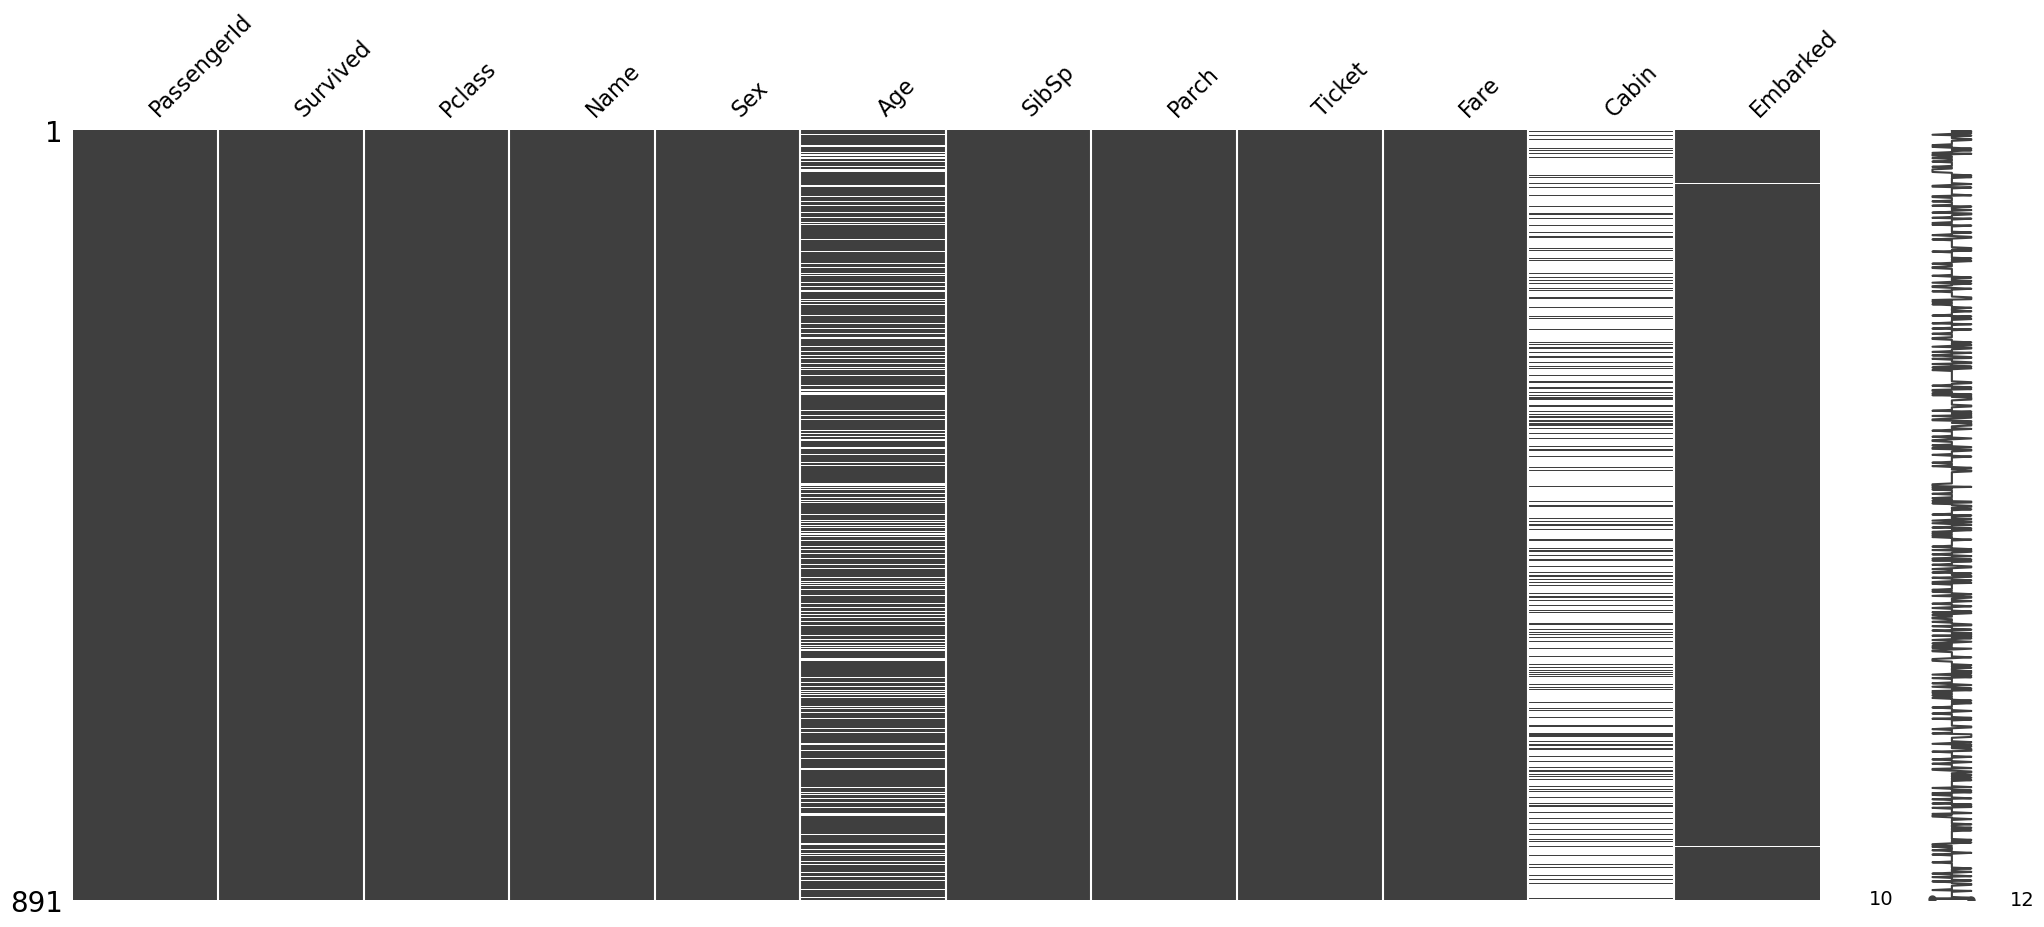

In [20]:
msno.matrix(df)
plt.show()

In [21]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Input missing value using Mean with Age and Class, based on data exploration

In [22]:
df["Age"] = df["Age"].replace(np.NaN, df["Age"].mean())
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [23]:
df = df.drop(["Cabin"], axis=1)

Remove the two samples that have 2 missing value from feature Embarked

In [24]:
df = df.dropna()
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

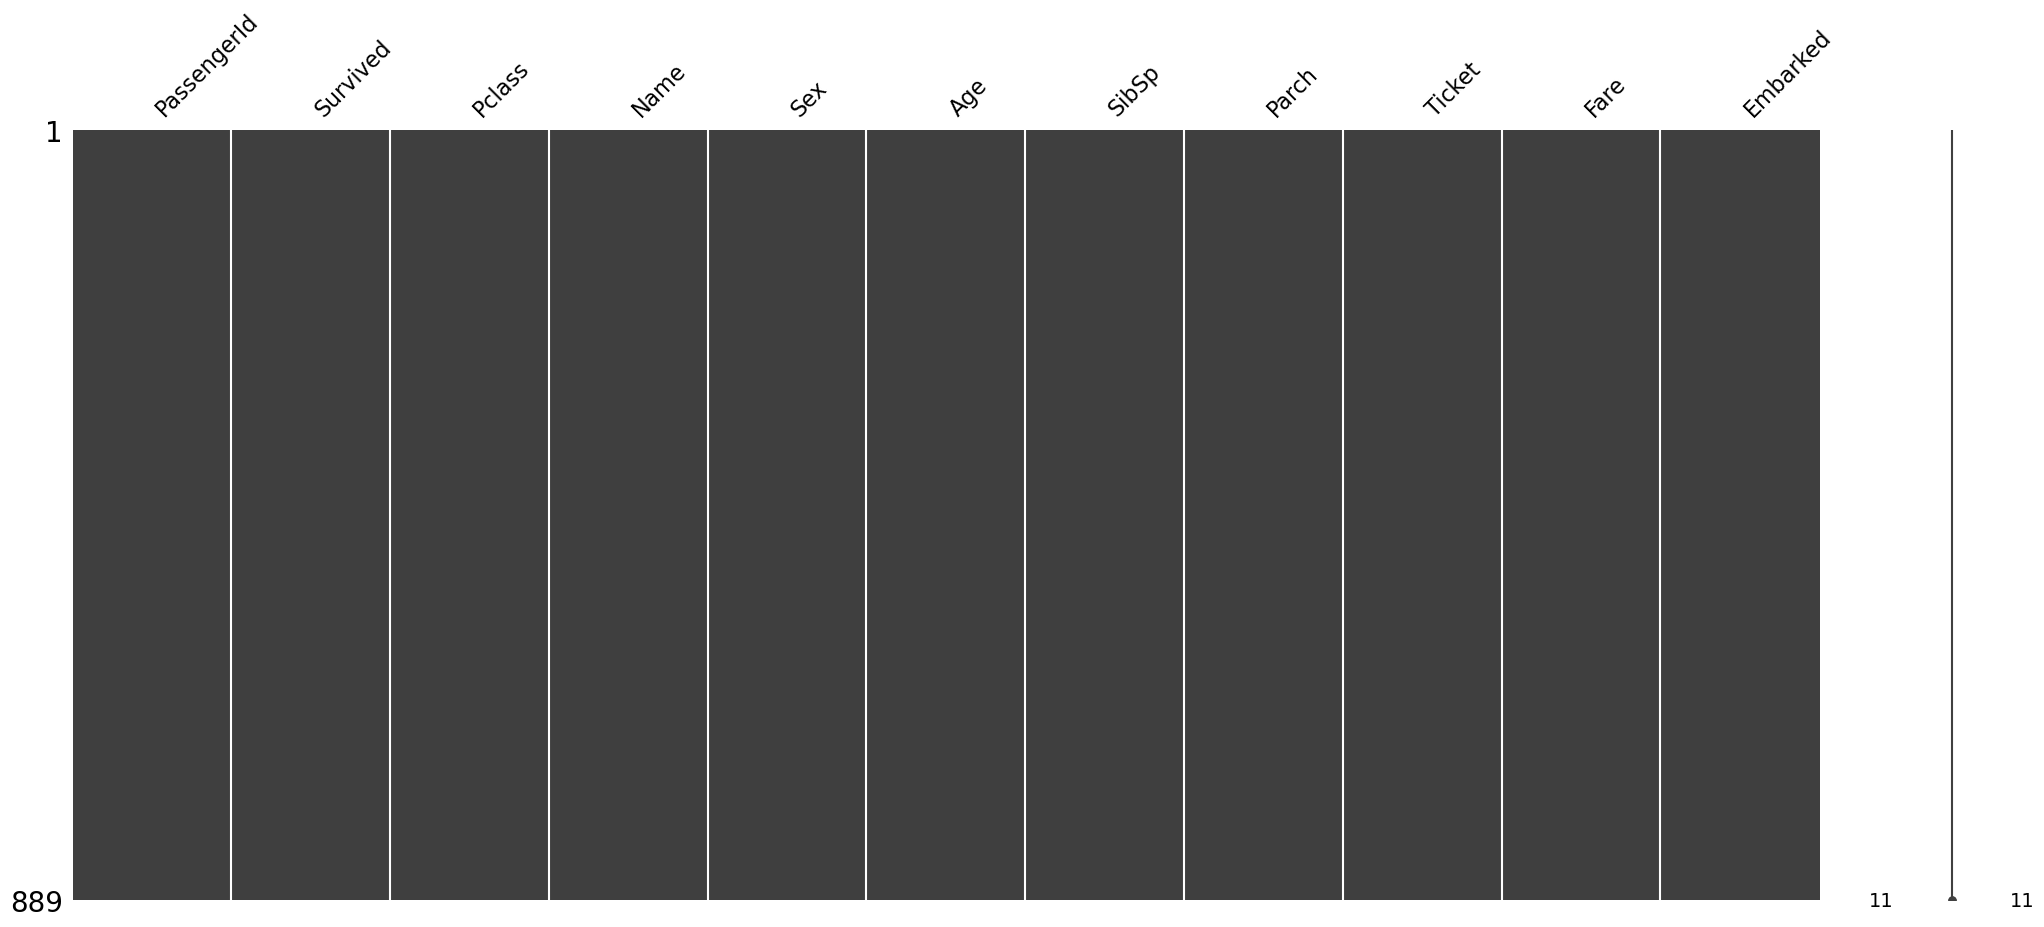

In [25]:
msno.matrix(df)
plt.show()

# Feature Engineering

In [26]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Add Title feature

This feature will be create with base the name field

In [27]:
def substring_in_string(big_string, substrings):
    for substring in substrings:
        if (substring in big_string):
            return substring
    print(big_string)
    return np.nan


def replace_title(x):
    title=x["Title"]
    if (title in ["Don", "Major", "Capt", "Jonkheer", "Rev", "Col"]):
        return "Mr"
    elif (title in ["Countess", "Mme"]):
        return "Mrs"
    elif (title in ["Mlle", "Ms"]):
        return "Miss"
    elif title == "Dr":
        if (x["Sex"] == "Male"):
            return "Mr"
        else:
            return "Mrs"
    else:
        return title

In [28]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']
print(df["Name"].values[0])
substring_in_string(df["Name"].values[0], title_list)

Braund, Mr. Owen Harris


'Mr'

In [29]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']
df["Title"] = df["Name"].map(lambda x: substring_in_string(x, title_list))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


In [30]:
df["Title"] = df.apply(replace_title, axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


## Get Ticket Number and Item from Ticket Feature

In [31]:
def get_ticket_number(x):
    return x.split(' ')[-1]
        
def get_ticket_item(x):
    items = x.split(' ')
    if (len(items) == 1):
        return "NONE"
    return '_'.join(items[0:-1])
    
df["Ticket_Number"] = df["Ticket"].apply(get_ticket_number)
df["Ticket_Item"] = df["Ticket"].apply(get_ticket_item)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_Number,Ticket_Item
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,21171,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,17599,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,3101282,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,113803,NONE
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,373450,NONE


## SibSp and Parch are the correlated features

In [32]:
fig = px.density_contour(df, x="SibSp", y="Parch", color='Survived',
                        height=400, width=800)
fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.show()

Using this contours we can see the feature Parch and SibSp are correlated and we can define this features as the **family size**

In [33]:
df["Family Size"] = df["SibSp"] + df["Parch"]

In [34]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_Number,Ticket_Item,Family Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,21171,A/5,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,17599,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,3101282,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,113803,NONE,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,373450,NONE,0


## Age times PClass Because are Numbers

In [35]:
df["Age*Class"] = df["Age"]*df["Pclass"]
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_Number,Ticket_Item,Family Size,Age*Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,Mr,21171,A/5,1,66.0


## Fare Per Person - Proportion

In [36]:
df["Fare_Per_Person"] = df["Fare"]/(df["Family Size"]+1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Ticket_Number,Ticket_Item,Family Size,Age*Class,Fare_Per_Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,21171,A/5,1,66.0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,17599,PC,1,38.0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,3101282,STON/O2.,0,78.0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,113803,NONE,1,35.0,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,373450,NONE,0,105.0,8.05000


## Remove Some Unsual Features

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      889 non-null    int64  
 1   Survived         889 non-null    int64  
 2   Pclass           889 non-null    int64  
 3   Name             889 non-null    object 
 4   Sex              889 non-null    object 
 5   Age              889 non-null    float64
 6   SibSp            889 non-null    int64  
 7   Parch            889 non-null    int64  
 8   Ticket           889 non-null    object 
 9   Fare             889 non-null    float64
 10  Embarked         889 non-null    object 
 11  Title            889 non-null    object 
 12  Ticket_Number    889 non-null    object 
 13  Ticket_Item      889 non-null    object 
 14  Family Size      889 non-null    int64  
 15  Age*Class        889 non-null    float64
 16  Fare_Per_Person  889 non-null    float64
dtypes: float64(4), i

In [38]:
df = df.drop(["PassengerId", "Name", 
    "SibSp", "Parch"], axis=1)
df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Title,Ticket_Number,Ticket_Item,Family Size,Age*Class,Fare_Per_Person
0,0,3,male,22.0,A/5 21171,7.2500,S,Mr,21171,A/5,1,66.0,3.62500
1,1,1,female,38.0,PC 17599,71.2833,C,Mrs,17599,PC,1,38.0,35.64165
2,1,3,female,26.0,STON/O2. 3101282,7.9250,S,Miss,3101282,STON/O2.,0,78.0,7.92500
3,1,1,female,35.0,113803,53.1000,S,Mrs,113803,NONE,1,35.0,26.55000
4,0,3,male,35.0,373450,8.0500,S,Mr,373450,NONE,0,105.0,8.05000


# Preprocessing

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         889 non-null    int64  
 1   Pclass           889 non-null    int64  
 2   Sex              889 non-null    object 
 3   Age              889 non-null    float64
 4   Ticket           889 non-null    object 
 5   Fare             889 non-null    float64
 6   Embarked         889 non-null    object 
 7   Title            889 non-null    object 
 8   Ticket_Number    889 non-null    object 
 9   Ticket_Item      889 non-null    object 
 10  Family Size      889 non-null    int64  
 11  Age*Class        889 non-null    float64
 12  Fare_Per_Person  889 non-null    float64
dtypes: float64(4), int64(3), object(6)
memory usage: 97.2+ KB


In [40]:
categorical_df = df[["Pclass", "Sex", "Embarked", "Ticket", "Title", "Ticket_Number", "Ticket_Item"]]
numerical_df = df[["Age", "Fare", "Age*Class", "Family Size", "Fare_Per_Person"]]
y = df[["Survived"]]

## Handle with Numerical Features

In [41]:
numerical_df.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50,
                                   0.75, 0.90, 0.99])

,Age,Fare,Age*Class,Family Size,Fare_Per_Person
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,29.653446,32.096681,65.000488,0.906637,19.781204
std,12.968366,49.697504,32.972039,1.614703,35.767862
min,0.420000,0.000000,0.920000,0.000000,0.000000
1%,1.000000,0.000000,2.250000,0.000000,0.000000
5%,6.000000,7.225000,14.400000,0.000000,4.215000
10%,16.000000,7.550000,24.000000,0.000000,5.081933
25%,22.000000,7.895800,40.000000,0.000000,7.250000
50%,29.699118,14.454200,63.000000,0.000000,8.158300
75%,35.000000,31.000000,89.097353,1.000000,22.525000


Looking at this percentiles we have to check if has any outlier to capping

In [42]:
def outlier_cap(x):
    x = x.clip(lower=x.quantile(0.01))
    x = x.clip(upper=x.quantile(0.99))
    return x

In [43]:
numerical_df = numerical_df.apply(lambda x: outlier_cap(x))

In [44]:
numerical_df.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50,
                                   0.75, 0.90, 0.99])

,Age,Fare,Age*Class,Family Size,Fare_Per_Person
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,29.596450,31.118044,64.699206,0.883015,18.449413
std,12.781228,42.524308,31.901312,1.499187,24.323382
min,1.000000,0.000000,2.250000,0.000000,0.000000
1%,1.000000,0.000000,2.250000,0.000000,0.000000
5%,6.000000,7.225000,14.400000,0.000000,4.215000
10%,16.000000,7.550000,24.000000,0.000000,5.081933
25%,22.000000,7.895800,40.000000,0.000000,7.250000
50%,29.699118,14.454200,63.000000,0.000000,8.158300
75%,35.000000,31.000000,89.097353,1.000000,22.525000


### Feature Selection/Discretization - Numerical Features

VarianceThreshold will be remove all low-variance features. Can thus be used for unsupervised learning.

In [45]:
vt = VarianceThreshold(threshold=0)
vt.fit_transform(numerical_df)

# get columns to keep and create new dataframe with those only
cols = vt.get_support(indices=True)
num_feat_non_var = numerical_df.iloc[:, cols]

KBinsDiscretizer will be discretizes features into `k` bins.

In [46]:
kbdiscrete = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")

In [47]:
num_binned = pd.DataFrame(kbdiscrete.fit_transform(num_feat_non_var), index=num_feat_non_var.index,
                          columns=num_feat_non_var.columns).add_suffix('_Rank')
num_binned.head()     

,Age_Rank,Fare_Rank,Age*Class_Rank,Family Size_Rank,Fare_Per_Person_Rank
0,1.0,0.0,2.0,0.0,0.0
1,4.0,4.0,1.0,0.0,4.0
2,1.0,1.0,3.0,0.0,2.0
3,3.0,4.0,1.0,0.0,4.0
4,3.0,1.0,4.0,0.0,2.0


With this Rank features, we can check if the feature show a slop at all

Note: a strong slope is indicate of the feature's ability to discriminate the event from non event making it a good predictor

In [48]:
def check_slope():
    X_bin_combined = pd.concat([y, num_binned], axis=1, join="inner")
    for col in num_binned.columns:
        sns.lineplot(x=col, y=X_bin_combined["Survived"].mean(), data=X_bin_combined)
        sns.barplot(x=col, y="Survived", data=X_bin_combined, estimator=np.mean)
        plt.show()

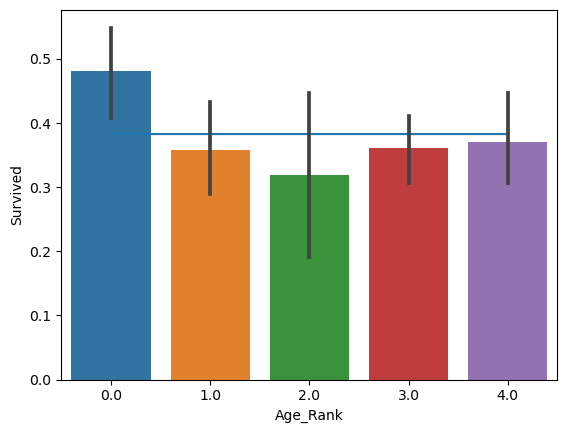

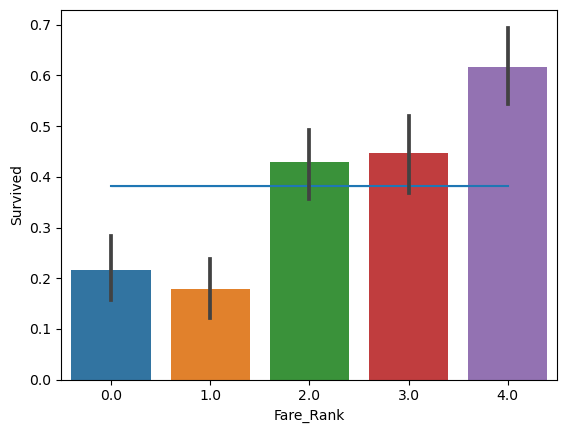

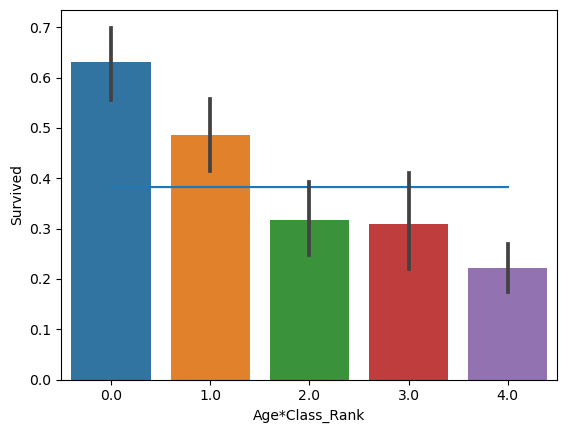

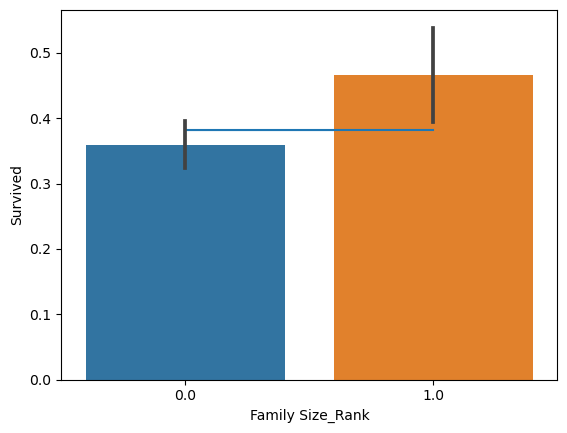

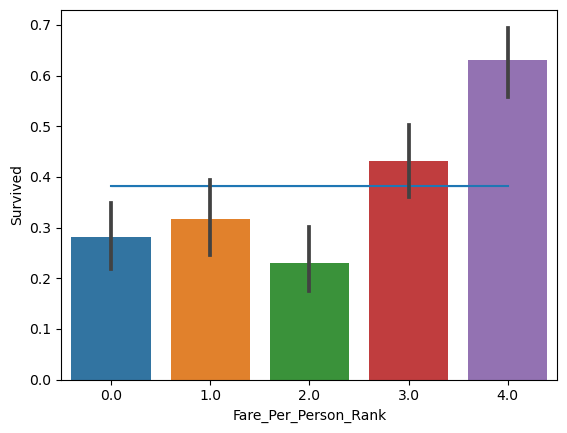

In [49]:
check_slope()

All feature has strong slope

In [50]:
select_feature_num_df = num_feat_non_var.copy()
select_feature_num_df.head()

,Age,Fare,Age*Class,Family Size,Fare_Per_Person
0,22.0,7.2500,66.0,1.0,3.62500
1,38.0,71.2833,38.0,1.0,35.64165
2,26.0,7.9250,78.0,0.0,7.92500
3,35.0,53.1000,35.0,1.0,26.55000
4,35.0,8.0500,105.0,0.0,8.05000


In [51]:
numerical = select_feature_num_df.columns.to_list()
numerical

['Age', 'Fare', 'Age*Class', 'Family Size', 'Fare_Per_Person']

## Handle with Categorical Features

### Feature Selection/Discretization

In [52]:
def check_categorical_slope():
    X_categorical_merged = pd.concat([y, categorical_df], axis=1)

    for col in categorical_df.columns:
        sns.lineplot(x=col, y=X_categorical_merged["Survived"].mean(),
                     data=X_categorical_merged)
        sns.barplot(x=col, y="Survived", data=X_categorical_merged,
                    estimator=np.mean)
        plt.show()

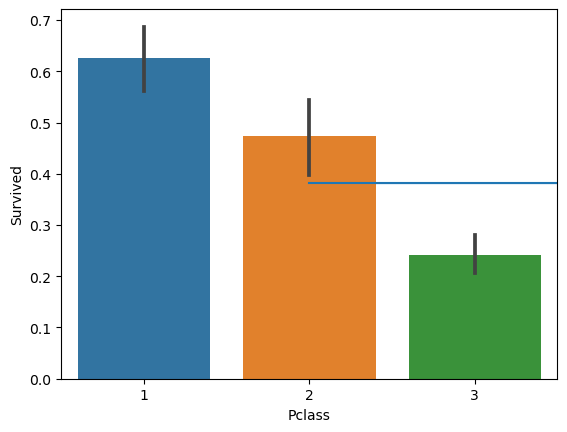

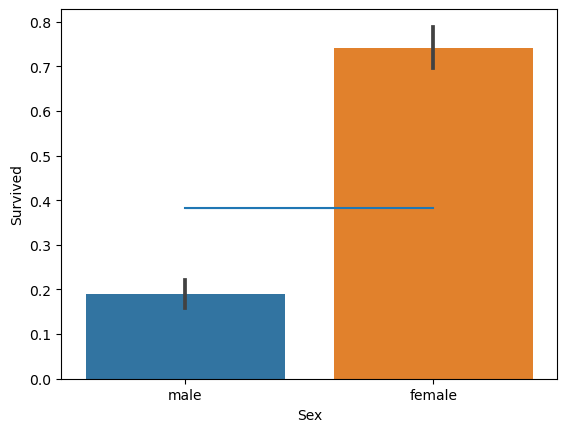

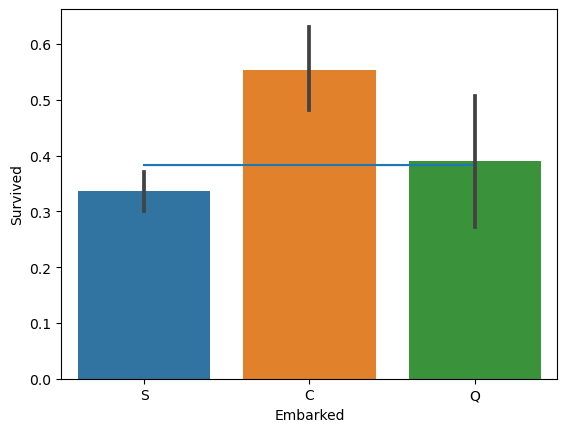

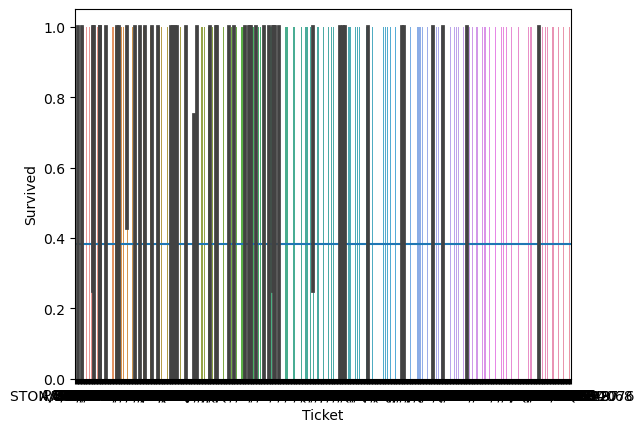

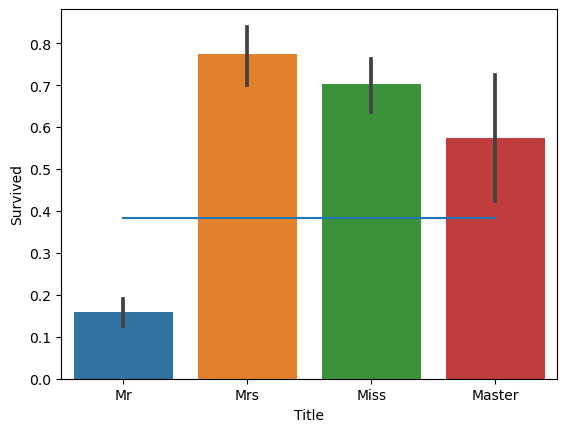

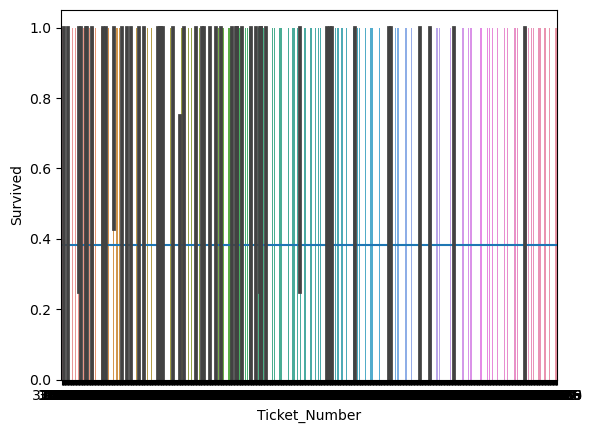

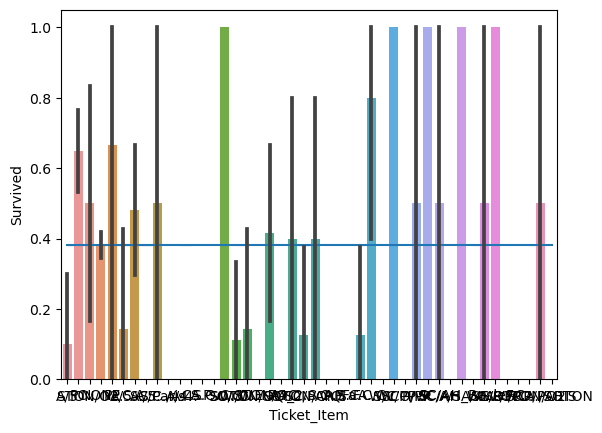

In [53]:
check_categorical_slope()

The Ticket feature have a weakly slope.

In [54]:
select_feature_cat_df = categorical_df.copy()
# select_feature_cat_df = categorical_df.drop("Ticket", axis=1)

select_feature_cat_df.head()

,Pclass,Sex,Embarked,Ticket,Title,Ticket_Number,Ticket_Item
0,3,male,S,A/5 21171,Mr,21171,A/5
1,1,female,C,PC 17599,Mrs,17599,PC
2,3,female,S,STON/O2. 3101282,Miss,3101282,STON/O2.
3,1,female,S,113803,Mrs,113803,NONE
4,3,male,S,373450,Mr,373450,NONE


### Dummies the Categorical Features

In [55]:
select_feature_cat_df.head()

,Pclass,Sex,Embarked,Ticket,Title,Ticket_Number,Ticket_Item
0,3,male,S,A/5 21171,Mr,21171,A/5
1,1,female,C,PC 17599,Mrs,17599,PC
2,3,female,S,STON/O2. 3101282,Miss,3101282,STON/O2.
3,1,female,S,113803,Mrs,113803,NONE
4,3,male,S,373450,Mr,373450,NONE


In [56]:
# lb = LabelEncoder() # for ordinal categorical features
ord = OrdinalEncoder(encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=-1) # for ordinal categorical feature
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown="ignore") # for nominal categorical features

In [57]:
ordinal = ["Pclass", ]
nominal = ["Sex", "Embarked", "Title", "Ticket_Item", "Ticket_Number"]

In [58]:
categorical_dum_df = select_feature_cat_df[ordinal].copy() # if I use LabelEncoder
# categorical_dum_df = pd.DataFrame()
categorical_dum_df.shape

(889, 1)

In [59]:
# for LabelEncoder()
# for ord_feat in ordinal:
    # categorical_dum_df[ord_feat] = lb.fit_transform(select_feature_cat_df[ord_feat].values.reshape(-1,))

# for ordinal encoder    
categorical_dum_df[ordinal] =  ord.fit_transform(select_feature_cat_df[ordinal].astype("object").values)

categorical_dum_df.head()

,Pclass
0,2.0
1,0.0
2,2.0
3,0.0
4,2.0


In [60]:
categorical_dum_df.shape

(889, 1)

In [61]:
categorical_dum_df.tail()

,Pclass
886,1.0
887,0.0
888,2.0
889,0.0
890,2.0


In [62]:
nominal_feat = one_hot_enc.fit_transform(select_feature_cat_df[nominal])
nominal_feat = pd.DataFrame(nominal_feat, columns=["nom_feat"+str(i+1).zfill(2) for i in range(nominal_feat.shape[1])])
nominal_feat.tail()

,nom_feat01,nom_feat02,nom_feat03,nom_feat04,nom_feat05,nom_feat06,nom_feat07,nom_feat08,nom_feat09,nom_feat10,...,nom_feat722,nom_feat723,nom_feat724,nom_feat725,nom_feat726,nom_feat727,nom_feat728,nom_feat729,nom_feat730,nom_feat731
884,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
885,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
categorical_dum_df.shape, nominal_feat.shape

((889, 1), (889, 731))

In [64]:

categorical_dum_df = pd.concat([categorical_dum_df.reset_index(drop=True), nominal_feat.reset_index(drop=True)], axis=1)

In [65]:
categorical_dum_df.head()

,Pclass,nom_feat01,nom_feat02,nom_feat03,nom_feat04,nom_feat05,nom_feat06,nom_feat07,nom_feat08,nom_feat09,...,nom_feat722,nom_feat723,nom_feat724,nom_feat725,nom_feat726,nom_feat727,nom_feat728,nom_feat729,nom_feat730,nom_feat731
0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Select K Best Categorical Features

This method removes all but the *k* highest scoring features

In [66]:
skb = SelectKBest(score_func=chi2, k="all")
skb.fit_transform(categorical_dum_df, y)
columns= skb.get_support(indices=True)
print(f"Number of columns selected: {len(columns)}")
select_feature_cat_df = categorical_dum_df.iloc[:, columns]

Number of columns selected: 732


In other hand, all 732 categorical feature has highet score.

## Put all Together

In [67]:
X = pd.concat([select_feature_cat_df.reset_index(drop=True), select_feature_num_df.reset_index(drop=True)], 
              axis=1, join="inner"
)
print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}")

Number of samples: 889, Number of features: 737


# Train/Test Split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

print(f"Amount of Train Samples: {len(X_train)}")
print(f"Amount of Test Samples: {len(X_test)}")

Amount of Train Samples: 800
Amount of Test Samples: 89


In [69]:
print(f"Number of feature: {X_train.shape[1]}")

Number of feature: 737


# Feature Scaling

In [70]:
scaler = StandardScaler()
scaler.fit(X_train[numerical])

StandardScaler()

In [71]:
X_train[numerical] = scaler.transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# Modeling

## Logistic Regression

**Build GridSearch Pipeline for Hyperparameter Tuning**

In [72]:
lr_pipeline = Pipeline([
    ("lr", LogisticRegression(penalty="l2", random_state=42))
])
lr_params = {
    "lr__C": [0.1, 1, 10, 100, 1000],
    "lr__solver": ["lbfgs", "newton-cg"],
    "lr__max_iter": [100, 500, 1000]
}
lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=10)
lr_grid.fit(X_train, y_train.values.reshape(-1,))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(random_state=42))]),
             param_grid={'lr__C': [0.1, 1, 10, 100, 1000],
                         'lr__max_iter': [100, 500, 1000],
                         'lr__solver': ['lbfgs', 'newton-cg']})

In [73]:
lr_grid.best_params_

{'lr__C': 10, 'lr__max_iter': 100, 'lr__solver': 'lbfgs'}

In [74]:
lr_grid.best_score_

0.84375

**Feature Importance**

In [75]:
lr = LogisticRegression(C=1, random_state=42, solver="lbfgs", max_iter=100)
lr.fit(X_train, y_train.values.reshape(-1, ))

LogisticRegression(C=1, random_state=42)

In [76]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns=["features"]
coeff_df["Coefficient Estimate"] = pd.Series(lr.coef_[0])
coeff_df.sort_values(["Coefficient Estimate"],ascending=False)

,features,Coefficient Estimate
147,nom_feat147,2.324091
6,nom_feat06,1.622388
48,nom_feat48,1.566120
513,nom_feat513,1.122984
628,nom_feat628,1.119207
...,...,...
668,nom_feat668,-0.933015
327,nom_feat327,-0.945405
0,Pclass,-1.102129
2,nom_feat02,-1.103159


**Evaluate the performance of Test Set**

In [77]:
lr_pred = lr_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), lr_pred)
f1 = f1_score(y_test.values.reshape(-1, ), lr_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8652, F1-score: 0.8125


## Support Vector Machine - SVM

**Build GridSearch Pipeline for Hyperparameter Tuning**

In [78]:
svm_pipeline = Pipeline([
    ("svm", SVC(random_state=42))
])
svm_params = {
    "svm__C": [0.1, 1, 10, 100, 500],
    "svm__gamma": [0.01, 0.01, 0.001],
    "svm__max_iter": [100, 500, 1000]
}
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=10)
svm_grid.fit(X_train, y_train.values.reshape(-1, ))

GridSearchCV(cv=10, estimator=Pipeline(steps=[('svm', SVC(random_state=42))]),
             param_grid={'svm__C': [0.1, 1, 10, 100, 500],
                         'svm__gamma': [0.01, 0.01, 0.001],
                         'svm__max_iter': [100, 500, 1000]})

In [79]:
svm_grid.best_params_

{'svm__C': 500, 'svm__gamma': 0.001, 'svm__max_iter': 500}

In [80]:
svm_grid.best_score_

0.8462500000000001

**Evaluate the performance of Test Set**

In [82]:
svm_pred = svm_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), svm_pred)
f1 = f1_score(y_test.values.reshape(-1, ), svm_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8539, F1-score: 0.7869


## Decision Tree 

**Build GridSearch Pipeline for Hyperparameter Tuning**

In [83]:
dt_pipeline = Pipeline([
    ("dt", DecisionTreeClassifier(random_state=42))
])
dt_params = {
    'dt__max_depth': [None, 3, 5, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': [None, 'sqrt', 'log2']
}
dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=10)
dt_grid.fit(X_train, y_train.values.reshape(-1, ))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__max_depth': [None, 3, 5, 10],
                         'dt__max_features': [None, 'sqrt', 'log2'],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10]})

In [84]:
dt_grid.best_params_

{'dt__max_depth': 10,
 'dt__max_features': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 5}

In [85]:
dt_grid.best_score_

0.8424999999999999

**Evaluate the performance of Test Set**

In [86]:
dt_pred = dt_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), dt_pred)
f1 = f1_score(y_test.values.reshape(-1, ), dt_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8315, F1-score: 0.7619


## Random Forest

**Build GridSearchCV Pipeline for Hyperparameter Tuning**

In [87]:
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])
rf_params = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 5, 10]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=10)
rf_grid.fit(X_train, y_train.values.reshape(-1,))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': [100, 200, 300]})

In [88]:
rf_grid.best_params_

{'rf__max_depth': None, 'rf__n_estimators': 100}

In [89]:
rf_grid.best_score_

0.8450000000000001

**Feature Importance**

In [90]:
rf = RandomForestClassifier(max_depth=None, n_estimators=100)
rf.fit(X_train, y_train.values.reshape(-1, ))

RandomForestClassifier()

In [91]:
def plot_feature_importance(feature_importance):
    fig = go.Figure()

    fig.add_trace(go.Bar(x=feature_importance["feature"], 
                         y=feature_importance["importance"]))

    # add annotations
    impo = feature_importance["importance"]
    
    for i, imp in enumerate(impo):
        fig.add_annotation(
            x=feature_importance["feature"][i],
            y=imp-0.8,
            text=f"{imp:.2f}%",
            showarrow=False,
            font=dict(color="white", size=12)
        )

    fig.update_layout(
        title="Feature Importance",
        xaxis_title="Features",
        yaxis_title="Importance (%)",
        width=900,
        height=500,
    )

    fig.show()

In [ ]:
# features_importances = pd.DataFrame({"importance": rf.feature_importances_},
#                                     index=[f"PC_{str(i+1)}" for i in range(pca_grid.best_estimator_.transform(X).shape[1])],
#                                     columns=["importance"]).sort_values("importance", ascending=False)
# features_importances = features_importances.reset_index()
# features_importances = features_importances.rename(columns={"index": "feature"})
# display(features_importances)

# plot_feature_importance(features_importances)     

**Evaluate the performance of Test Set**

In [93]:
rf_pred = rf_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), rf_pred)
f1 = f1_score(y_test.values.reshape(-1, ), rf_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8315, F1-score: 0.7692


## AdaBoost

**Build GridSearch Pipeline for Hyperparameter Tuning**

In [94]:
adaboost_pipeline = Pipeline([
    ("adaboost", AdaBoostClassifier())
])
adaboost_params = {
    "adaboost__n_estimators": [50, 100, 200],
    "adaboost__learning_rate": [0.1, 1, 10]
}
adaboost_grid = GridSearchCV(adaboost_pipeline, adaboost_params, cv=10)
adaboost_grid.fit(X_train, y_train.values.reshape(-1,))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('adaboost', AdaBoostClassifier())]),
             param_grid={'adaboost__learning_rate': [0.1, 1, 10],
                         'adaboost__n_estimators': [50, 100, 200]})

In [95]:
adaboost_grid.best_params_

{'adaboost__learning_rate': 1, 'adaboost__n_estimators': 200}

In [96]:
adaboost_grid.best_score_

0.8287500000000001

**Evaluate the performance of Test Set**

In [97]:
adaboost_pred = adaboost_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), adaboost_pred)
f1 = f1_score(y_test.values.reshape(-1, ), adaboost_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8427, F1-score: 0.7879


## Gradient Boosting

**Build GridSearchCV Pipeline for Hyperparameter Tuning**

In [98]:
grad_boost_pipeline = Pipeline([
    ("grad_boost", GradientBoostingClassifier(random_state=42))
])
grad_boost_params = {
    "grad_boost__n_estimators": [50, 100, 200, 500],
    "grad_boost__learning_rate": [0.1, 1, 10],
    "grad_boost__max_depth": [2, 4, 10]
}
grad_boost_grid = GridSearchCV(grad_boost_pipeline, grad_boost_params, cv=10)
grad_boost_grid.fit(X_train, y_train.values.reshape(-1,))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('grad_boost',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'grad_boost__learning_rate': [0.1, 1, 10],
                         'grad_boost__max_depth': [2, 4, 10],
                         'grad_boost__n_estimators': [50, 100, 200, 500]})

In [99]:
grad_boost_grid.best_params_

{'grad_boost__learning_rate': 0.1,
 'grad_boost__max_depth': 4,
 'grad_boost__n_estimators': 50}

In [100]:
grad_boost_grid.best_score_

0.8375

**Evaluate the performance of Test Set**

In [101]:
grad_boost_pred = grad_boost_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), grad_boost_pred)
f1 = f1_score(y_test.values.reshape(-1, ), grad_boost_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.7978, F1-score: 0.7273


## XGBoost

**Build a GridSearchCV Pipeline for Hyperparameter Tuning**

In [102]:
xgboost_pipeline = Pipeline([
    ("xgboost", XGBClassifier(random_state=42))
])
xgboost_params = {
    "xgboost__n_estimators": [50, 100, 200, 500, 1000],
    "xgboost__learning_rate": [0.001, 0.01, 0.05, 0.1],
    "xgboost__max_depth": [3, 6, 10],
    "xgboost__colsample_bytree": [0.3, 0.7]
}
xgboost_grid = GridSearchCV(xgboost_pipeline, xgboost_params, cv=10)
xgboost_grid.fit(X_train, y_train.values.reshape(-1, ))

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constrai...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             param_grid={'xgboost__colsample_bytree': [0.3, 0.7],
                         'xgboost__learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'xgboost__max_depth': [3, 6, 10],
                         'xgboost__n_estimators': [50, 100, 200, 500, 1000]})

In [103]:
xgboost_grid.best_params_

{'xgboost__colsample_bytree': 0.3,
 'xgboost__learning_rate': 0.01,
 'xgboost__max_depth': 6,
 'xgboost__n_estimators': 500}

In [104]:
xgboost_grid.best_score_

0.8400000000000001

**Evaluate the performance of Test Set**

In [105]:
xgboost_pred = xgboost_grid.predict(X_test)
acc = accuracy_score(y_test.values.reshape(-1, ), xgboost_pred)
f1 = f1_score(y_test.values.reshape(-1, ), xgboost_pred)
print(f"Accuracy: {round(acc,4)}, F1-score: {round(f1, 4)}")

Accuracy: 0.8315, F1-score: 0.7692


# Combine the Classifier Using Voting

In [106]:
ensemble_pred = (lr_pred + svm_pred + dt_pred + rf_pred + adaboost_pred + grad_boost_pred + xgboost_pred) // 7
acc = accuracy_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
print(f"Voting Accuracy: {round(acc,4)}, Voting F1-score: {round(f1, 4)}")

Voting Accuracy: 0.8539, Voting F1-score: 0.7719


# Apply in Test Set

## Load Sumission Set

In [107]:
df_test = pd.read_csv("../data/test.csv")
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Check missing values

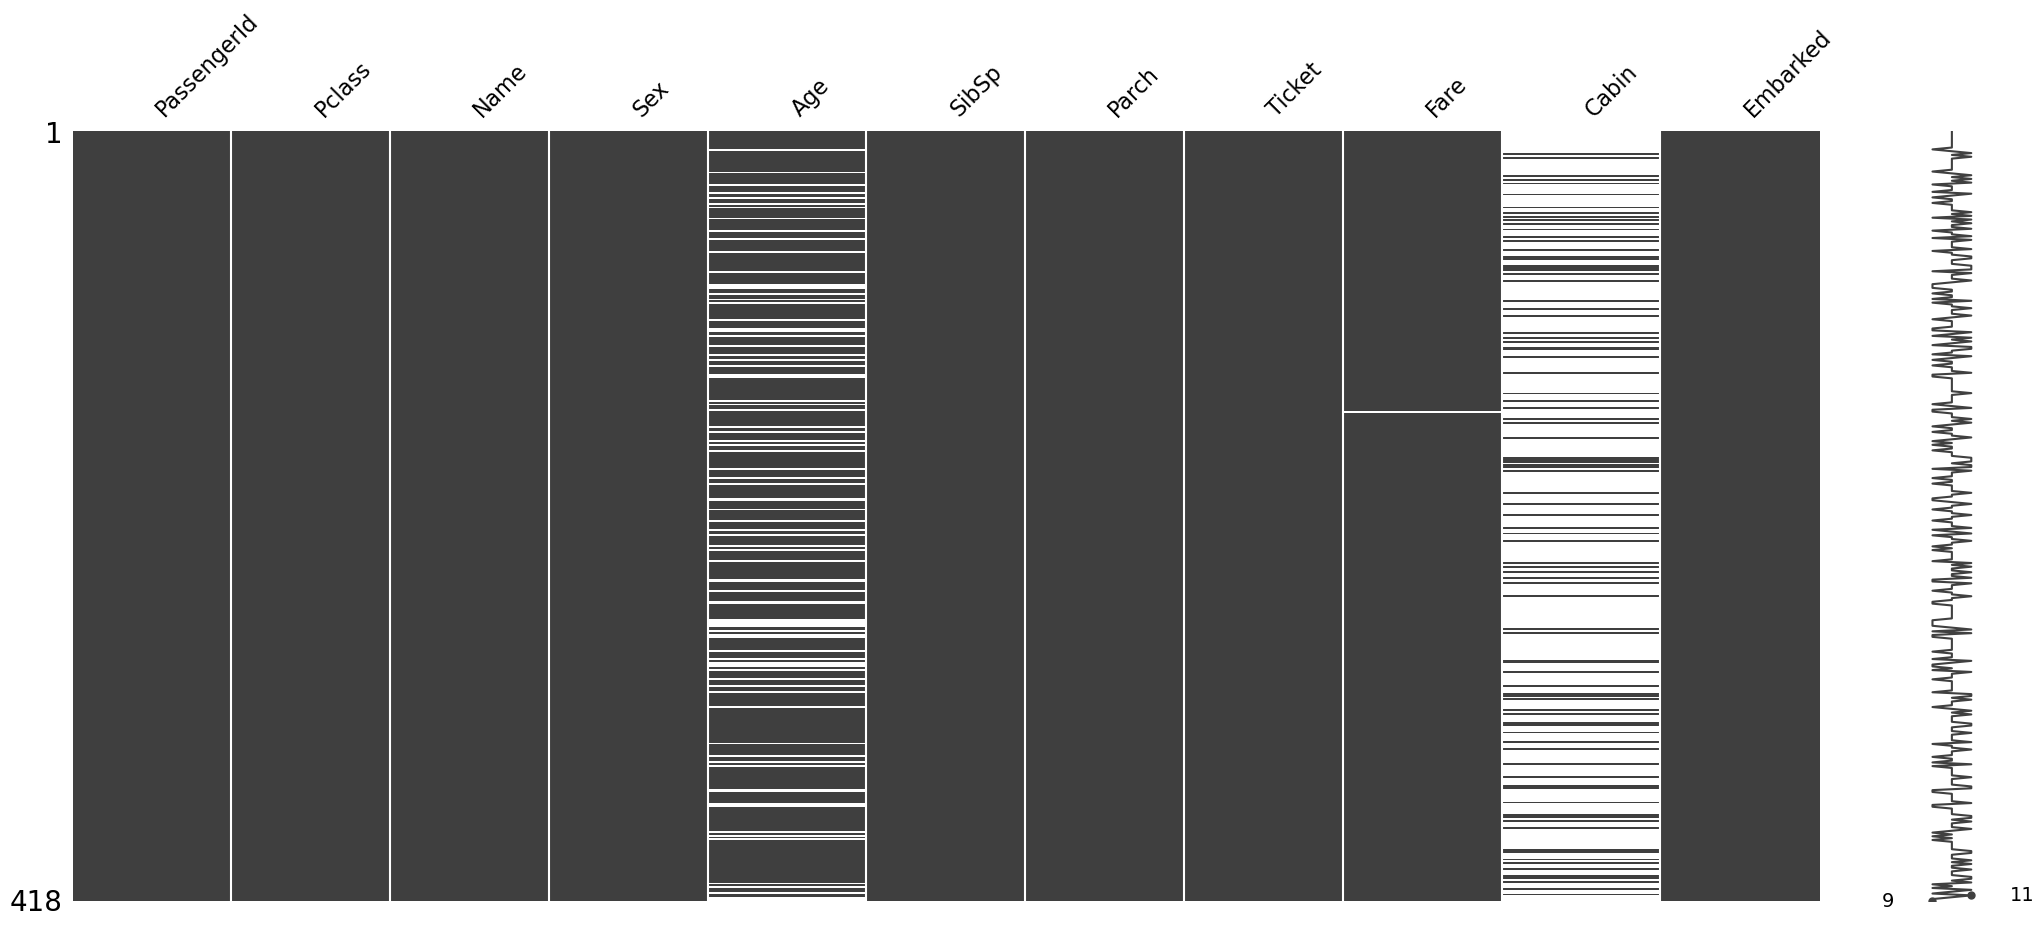

In [108]:
msno.matrix(df_test)
plt.show()

## Prediction Modules

In [109]:
def prediction_modules(df, classifier, name):
    feat_eng_df = df.copy()
    
    # handle with missing values
    feat_eng_df["Age"] = feat_eng_df["Age"].replace(np.NaN, feat_eng_df["Age"].mean())
    feat_eng_df["Fare"] = feat_eng_df["Fare"].replace(np.NaN, feat_eng_df["Age"].mean())
    # feature engineering
    feat_eng_df["Ticket_Number"] = feat_eng_df["Ticket"].apply(get_ticket_number)
    feat_eng_df["Ticket_Item"] = feat_eng_df["Ticket"].apply(get_ticket_item)
    feat_eng_df["Title"] = feat_eng_df["Name"].map(lambda x: substring_in_string(x, title_list))
    feat_eng_df["Title"] = feat_eng_df.apply(replace_title, axis=1)
    feat_eng_df["Family Size"] = feat_eng_df["SibSp"] + feat_eng_df["Parch"]
    feat_eng_df["Age*Class"] = feat_eng_df["Age"]*feat_eng_df["Pclass"]
    feat_eng_df["Fare_Per_Person"] = feat_eng_df["Fare"]/(feat_eng_df["Family Size"]+1)
    feat_eng_df = feat_eng_df.drop(["PassengerId", "Name", "SibSp", "Parch", "Cabin"], axis=1)


    categorical_df = feat_eng_df[["Pclass", "Sex", "Embarked", "Ticket", "Title", "Ticket_Number", "Ticket_Item"]]
    numerical_df = feat_eng_df[["Age", "Fare", "Age*Class", "Family Size", "Fare_Per_Person"]]

    vt.transform(numerical_df)

    cols = vt.get_support(indices=True)
    num_feat_non_var = numerical_df.iloc[:, cols]
    select_feature_num_df = num_feat_non_var.copy()
    
    # ordinal = ["Pclass", "Ticket_Number", "Ticket_Item"]
    # nominal = ["Sex", "Embarked", "Title"]
    select_feature_cat_df = categorical_df.copy()
    categorical_dum_df = select_feature_cat_df[ordinal].copy()
    categorical_dum_df[ordinal] =  ord.transform(categorical_dum_df[ordinal].astype("object").values)

    # for ord_feat in ordinal:
    #     categorical_dum_df[ord_feat] = lb.transform(select_feature_cat_df[ord_feat].values.reshape(-1,))
    
    # categorical_dum_df = pd.concat([categorical_dum_df, pd.get_dummies(select_feature_cat_df[nominal])], axis=1)
    nominal_feat = one_hot_enc.transform(select_feature_cat_df[nominal])
    nominal_feat = pd.DataFrame(nominal_feat, columns=["nom_feat"+str(i+1).zfill(2) for i in range(nominal_feat.shape[1])])
    

    categorical_dum_df = pd.concat([categorical_dum_df.reset_index(drop=True), nominal_feat.reset_index(drop=True)], axis=1)

    X = pd.concat([categorical_dum_df.reset_index(drop=True), select_feature_num_df.reset_index(drop=True)], 
                axis=1, join="inner"
    )
    print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}")
    X[numerical] = scaler.transform(X[numerical])
    pred = classifier.predict(X)
    return pd.DataFrame({"PassengerId": df["PassengerId"], "Survived": pred})

In [110]:
pd.read_csv("../data/gender_submission.csv").head(1)

,PassengerId,Survived
0,892,0


In [111]:
c_names = ["lr", "svm", "dt", "rf", "adaboost", "grad_boost", "xgboost"]
c_grids = [lr_grid, svm_grid, dt_grid, rf_grid, adaboost_grid, grad_boost_grid, xgboost_grid]

In [112]:
pred_clf = {}

In [113]:
for n, clf in zip(c_names, c_grids):
    print('-'*55)
    print(f"\t\t\t{n.upper()}\n")
    df_pred = prediction_modules(df_test, clf, n)
    df_pred.to_csv(f"../reports/subimission_{n}.csv", index=False)
    pred_clf[n] = df_pred["Survived"].values
    print('-'*55)

-------------------------------------------------------
			LR

Number of samples: 418, Number of features: 737
-------------------------------------------------------
-------------------------------------------------------
			SVM

Number of samples: 418, Number of features: 737
-------------------------------------------------------
-------------------------------------------------------
			DT

Number of samples: 418, Number of features: 737
-------------------------------------------------------
-------------------------------------------------------
			RF

Number of samples: 418, Number of features: 737
-------------------------------------------------------
-------------------------------------------------------
			ADABOOST

Number of samples: 418, Number of features: 737
-------------------------------------------------------
-------------------------------------------------------
			GRAD_BOOST

Number of samples: 418, Number of features: 737
---------------------------------------

In [114]:
len(pred_clf.keys())

7

In [115]:
pred_ensemble = (pred_clf["lr"] + pred_clf["svm"] + pred_clf["dt"] + pred_clf["rf"] +
                 pred_clf["adaboost"] + pred_clf["grad_boost"] + pred_clf["xgboost"]) //len(pred_clf.keys())
len(pred_ensemble)

418

In [116]:
df_pred_voting = pd.DataFrame({"PassengerId": df_test["PassengerId"].values.tolist(),
                               "Survived": pred_ensemble})
df_pred_voting.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [117]:
df_pred_voting.to_csv("../reports/ensemble_voting.csv", index=False)